In [1]:
import sys, os
from configobj import ConfigObj
from math import sqrt
import numpy as np
from astropy.io import fits
from multicens import multiCens
import matplotlib.pyplot as plt
from circle_fit import standardLSQ

In [2]:
def distance(a,b):
    return sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [12]:
def unpack_conf(filename):
    config = ConfigObj(filename)
    x = []
    y = []
    can_ids = []
    for centroid in config.values():
        x.append(float(centroid['x_coord']))
        y.append(float(centroid['y_coord']))
        can_ids.append(centroid['can_id'])
    return x, y, can_ids

In [5]:
def unpack_fiducial_conf(filename):
    config = ConfigObj(filename)
    fid_list = []
    for fid in config.values():
        fid_list.append([float(fid['x_coord']), float(fid['y_coord'])])
    return sorted(fid_list, key=lambda x: x[0])

frames = []
directory = '/home/sharonye/DESI/lab_machine/trim/data/241017_062755_fiducial_calibration'
for file in os.scandir(directory):
    if file.path.endswith('fiducials.conf'):
        frames.append(unpack_fiducial_conf(file.path))

xs = []
ys = []
for frame in frames:
    xs.append(frame[0][0])
    ys.append(frame[0][1])
print(xs)
print(ys)
print(np.std(xs), np.std(ys))
print(sqrt(np.std(xs) ** 2 + np.std(ys) ** 2))

[1356.9258284529265, 1356.9171204863217, 1356.9241778889, 1356.9279122143132, 1356.9170756011742, 1356.9186856381584, 1356.9158622759776, 1356.9182494784259, 1356.9314528552175, 1356.916680839679]
[1696.4933960990677, 1696.4871394526383, 1696.5077718124587, 1696.4711678710182, 1696.4043654202637, 1696.49252645946, 1696.4638038465416, 1696.5192641801482, 1696.4796515264022, 1696.472012135119]
0.005272103022887947 0.029693778271632613
0.030158175314975957


In [6]:
fids = unpack_fiducial_conf('/home/sharonye/DESI/lab_machine/trim/data/241017_062755_fiducial_calibration/241017_062755_fiducials.conf')
print(fids)

[[1356.9258284529265, 1696.4933960990677], [1368.3444915996772, 1676.222356100144], [1376.1602903785072, 1694.1642031191845], [1383.7966315404897, 1711.9299164162883]]


In [7]:
def camera_scale_from_fiducial(fiducials):
    dist_0_1 = distance(fiducials[0], fiducials[1]) # should be 1.2mm
    dist_0_3 = distance(fiducials[0], fiducials[3]) # should be 1.6mm
    dist_1_3 = distance(fiducials[1], fiducials[3]) # should be 2mm
    return np.mean([1200/dist_0_1, 1600/dist_0_3, 2000/dist_1_3])

camera_scale_from_fiducial(fids)

51.537526695440306

In [8]:
hdul = fits.open('/home/sharonye/DESI/lab_machine/trim/data/241024_062326_positioner_matching/centroids_zwo_241024_062328.fits')
image = hdul[0].data
X, Y, peaks, FWHM, _ = multicens.multiCens(image, n_centroids_to_keep=17, verbose=False, write_fits=False, size_fitbox=7)

plt.plot(X, Y, 'o')

FileNotFoundError: [Errno 2] No such file or directory: '/home/sharonye/DESI/lab_machine/trim/data/241024_062326_positioner_matching/centroids_zwo_241024_062328.fits'

In [9]:
im_b = fits.open('/home/sharonye/DESI/lab_machine/trim/data/241027_045108_positioner_matching/centroids_zwo_241027_045110.fits')[0].data
im_a = fits.open('/home/sharonye/DESI/lab_machine/trim/data/241027_045108_positioner_matching/centroids_zwo_241027_045202.fits')[0].data

x_b, y_b, p_b, f_b, _b = multicens.multiCens(im_b, n_centroids_to_keep=17, verbose=False, write_fits=False, size_fitbox=7)
x_a, y_a, p_a, f_a, _a = multicens.multiCens(im_a, n_centroids_to_keep=17, verbose=False, write_fits=False, size_fitbox=7)

plt.plot(x_b, y_b, 'bo')
plt.plot(x_a, y_a, 'ro')

NameError: name 'multicens' is not defined

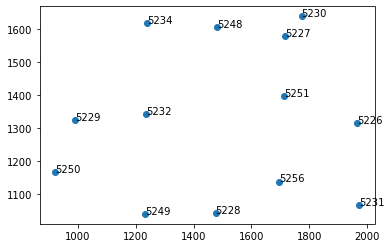

In [13]:
X, Y, ids = unpack_conf('/home/sharonye/DESI/lab_machine/trim/data/250228_065518_positioner_matching/positioners.conf')
fig, ax = plt.subplots()
ax.plot(X, Y, 'o')
for i, label in enumerate(ids):
    ax.text(X[i], Y[i], label)

[[(895.469985947106, 1753.9651304854217, '5249')], [(614.5668792073084, 1410.072942932587, '5232'), (863.4281554178565, 1459.8207311652934, '5228'), (1135.2316256915137, 1472.7722987086959, '5251'), (1446.5718547304011, 1461.4173981847484, '5250'), (1709.308274055617, 1473.4909619135651, '5231'), (2072.3725807336355, 1346.3661472642607, '5234')], [(399.8395088399552, 1070.4628439783896, '5256'), (682.3118146157329, 1024.768285851694, '5227'), (971.202489590738, 1029.9500569433274, '5229'), (1362.5438691376921, 913.8465560720425, '5226'), (1783.1849139483259, 998.4255377638665, '5230'), (2077.5312943431536, 1022.5268471923464, '5248')]]


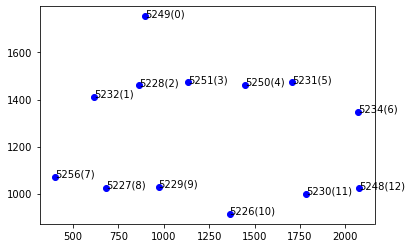

In [76]:
points = list(zip(X, Y, ids))
points = sorted(points, key=lambda x:x[1], reverse=True)
split = []
prev = 0
for i in range(len(points) - 1):
    if abs(points[i][1]-points[i+1][1]) > 100:
        split.append(points[prev:i+1])
        prev = i + 1
split.append(points[prev:])
for i in range(len(split)):
    split[i] = sorted(split[i], key=lambda x:x[0])

fig, ax = plt.subplots()
counter = 0
for row in split:
    for point in row:
        plt.plot(point[0], point[1], 'bo')
        ax.text(point[0], point[1], f"{point[2]}({counter})")
        counter = counter + 1

print(split)

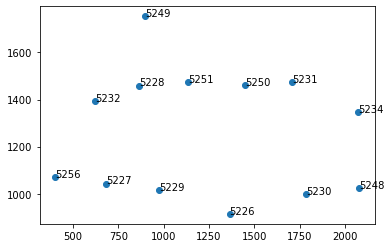

In [39]:
X, Y, ids = unpack_conf('/home/sharonye/DESI/lab_machine/trim/data/241027_065258_positioner_matching/positioners.conf')
fig, ax = plt.subplots()
ax.plot(X, Y, 'o')
for i, label in enumerate(ids):
    ax.text(X[i], Y[i], label)

peak = 85448.93526051767 brightness appears out of expected range
peak = 97585.81251408171 brightness appears out of expected range
peak = 70816.4466304986 brightness appears out of expected range
peak = 66548.58269725139 brightness appears out of expected range
peak = 85403.87828180812 brightness appears out of expected range
peak = 97822.90751117568 brightness appears out of expected range
peak = 70877.72438284577 brightness appears out of expected range
peak = 66508.86274907594 brightness appears out of expected range


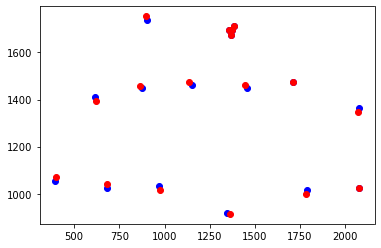

In [40]:
im_b = fits.open('/home/sharonye/DESI/lab_machine/trim/data/241027_065258_positioner_matching/centroids_zwo_241027_065300.fits')[0].data
im_a = fits.open('/home/sharonye/DESI/lab_machine/trim/data/241027_065258_positioner_matching/centroids_zwo_241027_065354.fits')[0].data

x_b, y_b, p_b, f_b, _b = multicens.multiCens(im_b, n_centroids_to_keep=17, verbose=False, write_fits=False, size_fitbox=7)
x_a, y_a, p_a, f_a, _a = multicens.multiCens(im_a, n_centroids_to_keep=17, verbose=False, write_fits=False, size_fitbox=7)

plt.plot(x_b, y_b, 'bo')
plt.plot(x_a, y_a, 'ro')

744.6567879632406 1666.505274556511 57.43611271226688 0.3283488137455005
radius in microns: 2957.110989027505, error in microns = 42.889010972494816
std in microns: 16.905111427458984


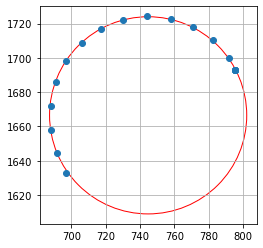

In [96]:
from circle_fit import standardLSQ

points = [[(696.5601421602892, 1633.180610010587)], [(691.7990352557472, 1644.7385170969008)], [(688.1726032248212, 1658.1890629834986)], [(687.7795513754415, 1672.0599660625533)], [(690.7892969601897, 1685.672497042194)], [(697.0711969174356, 1698.2849864511181)], [(706.038620576752, 1708.8652037382942)], [(717.3494748038747, 1717.071049638923)], [(730.209521038704, 1722.2741330219008)], [(743.9361845584666, 1724.22984669389)], [(757.7929624253586, 1722.6992844849467)], [(770.7843388668564, 1717.9717308297188)], [(782.2704818987581, 1710.2200024106567)], [(791.4707901514604, 1699.8071259975766)], [(795.3449681319933, 1693.1846768040507)], [(795.3349404529482, 1693.193186455445)], [(795.3395519627711, 1693.195384625936)], [(795.291363843944, 1693.1721301409939)], [(795.3018085799033, 1693.155730589266)]]
mpp = 51.48522156855406
points_list = []
points_x = []
points_y = []
for point in points:
    points_x.append(point[0][0])
    points_y.append(point[0][1])
    points_list.append(list(point[0]))
ax = plt.gca()
ax.set_aspect('equal')
plt.grid()
plt.plot(points_x, points_y, 'o')

x, y, r, s = standardLSQ(points_list)
circ_approx = plt.Circle((x, y), r, color='r', fill=False)
ax.add_patch(circ_approx)
print(x, y, r, s)
print(f"radius in microns: {r * mpp}, error in microns = {abs(3000 - r * mpp)}")

print(f"std in microns: {s * mpp}")

744.6607666648971 1666.9778153751467 57.125769473550655 0.11951856567805037
radius in microns: 2941.1328986198973, error in microns = 58.86710138010267
std in microns: 6.153439835490204


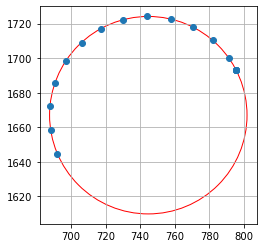

In [99]:
points = [[(691.7990352557472, 1644.7385170969008)], [(688.1726032248212, 1658.1890629834986)], [(687.7795513754415, 1672.0599660625533)], [(690.7892969601897, 1685.672497042194)], [(697.0711969174356, 1698.2849864511181)], [(706.038620576752, 1708.8652037382942)], [(717.3494748038747, 1717.071049638923)], [(730.209521038704, 1722.2741330219008)], [(743.9361845584666, 1724.22984669389)], [(757.7929624253586, 1722.6992844849467)], [(770.7843388668564, 1717.9717308297188)], [(782.2704818987581, 1710.2200024106567)], [(791.4707901514604, 1699.8071259975766)], [(795.3449681319933, 1693.1846768040507)], [(795.3349404529482, 1693.193186455445)], [(795.3395519627711, 1693.195384625936)], [(795.291363843944, 1693.1721301409939)], [(795.3018085799033, 1693.155730589266)]]
mpp = 51.48522156855406
points_list = []
points_x = []
points_y = []
for point in points:
    points_x.append(point[0][0])
    points_y.append(point[0][1])
    points_list.append(list(point[0]))
ax = plt.gca()
ax.set_aspect('equal')
plt.grid()
plt.plot(points_x, points_y, 'o')

x, y, r, s = standardLSQ(points_list)
circ_approx = plt.Circle((x, y), r, color='r', fill=False)
ax.add_patch(circ_approx)
print(x, y, r, s)
print(f"radius in microns: {r * mpp}, error in microns = {abs(3000 - r * mpp)}")

print(f"std in microns: {s * mpp}")

564.5850991300555 1026.3324419839964 59.33149217407686 0.42732129167500343
radius in microns: 3054.6950205752782, error in microns = 54.69502057527825
std in microns: 22.00073138284827


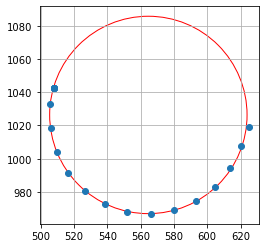

In [97]:
points = [[(624.98229088435, 1019.3709526404751)], [(620.0574770342212, 1007.5024511287272)], [(613.8846572138624, 994.4600824627441)], [(604.7936321232869, 983.2847339435745)], [(593.4383487748909, 974.5887683805166)], [(580.2063924695889, 969.0612810852773)], [(566.0001715073352, 966.8369975967054)], [(551.7254155399272, 968.2021865504557)], [(538.2549314506333, 972.9534205989493)], [(526.2923445327119, 980.8309364545427)], [(516.453615025489, 991.5501437093991)], [(509.5380884812308, 1004.1674124537901)], [(505.8600668068472, 1018.2219437128554)], [(505.6211161211137, 1032.6513010345247)], [(507.7601425191276, 1042.7488347224487)], [(507.5966731491512, 1042.5478160636633)], [(507.5633942948835, 1042.6611479945097)], [(507.5635494441555, 1042.6453323577316)], [(507.5649474612587, 1042.7332536637998)]]
mpp = 51.48522156855406
points_list = []
points_x = []
points_y = []
for point in points:
    points_x.append(point[0][0])
    points_y.append(point[0][1])
    points_list.append(list(point[0]))
ax = plt.gca()
ax.set_aspect('equal')
plt.grid()
plt.plot(points_x, points_y, 'o')

x, y, r, s = standardLSQ(points_list)
circ_approx = plt.Circle((x, y), r, color='r', fill=False)
ax.add_patch(circ_approx)
print(x, y, r, s)
print(f"radius in microns: {r * mpp}, error in microns = {abs(3000 - r * mpp)}")

print(f"std in microns: {s * mpp}")

564.1629499108152 1025.8826937399338 58.930453953049636 0.10222617868069651
radius in microns: 3034.047478908233, error in microns = 34.04747890823319
std in microns: 5.263137459482257


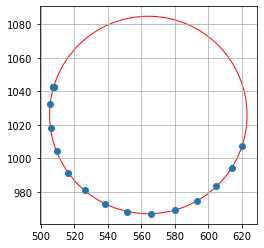

In [98]:
points = [[(620.0574770342212, 1007.5024511287272)], [(613.8846572138624, 994.4600824627441)], [(604.7936321232869, 983.2847339435745)], [(593.4383487748909, 974.5887683805166)], [(580.2063924695889, 969.0612810852773)], [(566.0001715073352, 966.8369975967054)], [(551.7254155399272, 968.2021865504557)], [(538.2549314506333, 972.9534205989493)], [(526.2923445327119, 980.8309364545427)], [(516.453615025489, 991.5501437093991)], [(509.5380884812308, 1004.1674124537901)], [(505.8600668068472, 1018.2219437128554)], [(505.6211161211137, 1032.6513010345247)], [(507.7601425191276, 1042.7488347224487)], [(507.5966731491512, 1042.5478160636633)], [(507.5633942948835, 1042.6611479945097)], [(507.5635494441555, 1042.6453323577316)], [(507.5649474612587, 1042.7332536637998)]]
mpp = 51.48522156855406
points_list = []
points_x = []
points_y = []
for point in points:
    points_x.append(point[0][0])
    points_y.append(point[0][1])
    points_list.append(list(point[0]))
ax = plt.gca()
ax.set_aspect('equal')
plt.grid()
plt.plot(points_x, points_y, 'o')

x, y, r, s = standardLSQ(points_list)
circ_approx = plt.Circle((x, y), r, color='r', fill=False)
ax.add_patch(circ_approx)
print(x, y, r, s)
print(f"radius in microns: {r * mpp}, error in microns = {abs(3000 - r * mpp)}")

print(f"std in microns: {s * mpp}")

In [110]:
def listify(zip_obj):
    list_obj = []
    for obj in zip_obj:
        list_obj.append(list(obj))
    return list_obj

test1 = ['a', 'b', 'c']
test2 = [1, 2, 3]

obj = zip(test1, test2)
l = listify(obj)
print(l)

[list(t) for t in zip(*l)]

[['a', 1], ['b', 2], ['c', 3]]


[['a', 'b', 'c'], [1, 2, 3]]

In [112]:
for i, v in enumerate(test1):
    print(i)
    print(v)

0
a
1
b
2
c


737.3735243790944 1684.2266611254006 57.09350989715904 0.11544093595949169
radius in microns: 2939.4720071816673, error in microns = 60.52799281833268
std in microns: 5.94350216595569


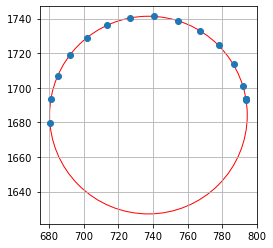

In [10]:
points = [[680.2893058135672, 1679.526700795112], [680.9219548327292, 1693.400343220855], [684.911220607716, 1706.7110538504091], [692.0575366408917, 1718.708785458236], [701.8541181884025, 1728.7122883489556], [713.7243933525726, 1736.0517059154654], [726.9896139653958, 1740.3362151068989], [740.8179539810739, 1741.2589304359806], [754.5362804039105, 1738.7489551694632], [767.2892407174446, 1733.0503018239754], [778.1117762061101, 1724.447536241423], [786.52767143764, 1713.5386369103521], [792.0486940428646, 1700.772468117716], [793.6536355725191, 1693.2314221183283], [793.6530871580271, 1693.2354593387402], [793.6494428780236, 1693.2241664971273], [793.6604563305264, 1693.2399606588967]]

mpp = 51.48522156855406
points_x = []
points_y = []
for point in points:
    points_x.append(point[0])
    points_y.append(point[1])
ax = plt.gca()
ax.set_aspect('equal')
plt.grid()
plt.plot(points_x, points_y, 'o')

x, y, r, s = standardLSQ(points)
circ_approx = plt.Circle((x, y), r, color='r', fill=False)
ax.add_patch(circ_approx)
print(x, y, r, s)
print(f"radius in microns: {r * mpp}, error in microns = {abs(3000 - r * mpp)}")

print(f"std in microns: {s * mpp}")

In [27]:
class Test:
    def __init__(self):
        self.a = 0
        self.b = 1
        self.c = 2
    
    def flush(self):
        for a, v in vars(self).items():
            print(v)
            
test = Test()
test.flush()
    

0
1
2


In [13]:
# Fiducial calibration with rotational orientation

a = [1366.2008558723878, 1355.3859652773745]
b = [1368.1142873916606, 1335.8617212397296]
c = [1380.1170283450765, 1346.8555549513130]
d = [1392.1362734218350, 1357.8535286173758]

points = []
points.append(a)
points.append(b)
points.append(c)
points.append(d)

distances = {}

for i in range(4):
    for j in range(i + 1, 4):
        distances[f'dist_{i}_{j}'] = distance(points[i], points[j])
        
print(distances)

{'dist_0_1': 19.61778084851742, 'dist_0_2': 16.322614883056996, 'dist_0_3': 26.052538308216644, 'dist_1_2': 16.276675645621125, 'dist_1_3': 32.568319031988615, 'dist_2_3': 16.291644391361952}


In [18]:
def camera_scale_from_fiducial(fiducials):
    distances = []
    for i in range(4):
        for j in range(i + 1, 4):
            distances.append(distance(fiducials[i], fiducials[j]))
    distances = sorted(distances)
    pixels = []
    for i in range(3):
        pixels.append(1000 / distances[i])
    pixels.append(1200 / distances[3])
    pixels.append(1600 / distances[4])
    pixels.append(2000 / distances[5])
    return np.mean(pixels)

In [19]:
camera_scale_from_fiducial(points)

[16.276675645621125, 16.291644391361952, 16.322614883056996, 19.61778084851742, 26.052538308216644, 32.568319031988615]


61.34603157602081